In [4]:
# Demo for visualisation of crop type and yield data
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# 3D stuff
from IPython.core.display import display, HTML
import json

import geopandas as gpd
import geojson
import pandas as pd

from functools import partial
from shapely.geometry import Point  # Point class
# shape() is a function to convert geo objects through the interface
from shapely.geometry import shape

#!pip install matplotlib
import matplotlib.pyplot as plt

/tmp/ipykernel_5968/1106638891.py:6: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


Example for crop type data

Crop type labels and id:

Bavaria:
Potatos: 600, 601, 602 
Winter barley: 476, 131
Winter rapeseed: 311, 489
Winter wheat: 115
Corn: 400, 177, 171, 411, 410
Sugar beet: 603

The labels for the following data are documented in:
Kenya:
https://mlhub.earth/data/ref_african_crops_kenya_01

Central Asia:
https://www.nature.com/articles/s41597-020-00591-2?proof=t

France:
https://breizhcrops.org/



In [5]:
# load shapefiles
centralasia_shp = gpd.read_file(
    "../data/cropdata/CentralAsia/CAWa_CropType_samples.shp")

durnast_shp = gpd.read_file(
    "../data/cropdata/Bavaria/bavaria_shs/labels_new.shp")

kenya_shp = gpd.read_file('../data/cropdata/Kenya/kenya_shs/labels_new.shp')

# load sentinel-2 timeseries L2A for shapefiles
# The timeseries are from GEE and Sentinel Hub
# Sentinel hub provides a FIS API and a new SHS API. Both data sets are included
# the timeseries for both levels L1C and L2A are available
# https://sentinelhub-py.readthedocs.io/en/latest/examples/fis_request.html
# all data from Sentinel hub is cloud free

durnast_ts = pd.read_excel(
    "../data/cropdata/Bavaria/bavaria_shs/timeseries_L2A.xlsx")

kenya_ts = pd.read_excel(
    '../data/cropdata/Kenya/kenya_shs/timeseries_L2A.xlsx')

# data set from GEE Level 1C
bavaria_train = pd.read_excel(
    "../data/cropdata/Bavaria/sentinel-2/Training_bavaria.xlsx")
bavaria_test = pd.read_excel(
    "../data/cropdata/Bavaria/sentinel-2/Test_bavaria.xlsx")
bavaria_reordered = pd.read_excel(
    '../data/cropdata/Bavaria/sentinel-2/data2016-2018.xlsx', index_col=0)
bavaria_test_reordered = pd.read_excel(
    '../data/cropdata/Bavaria/sentinel-2/TestData.xlsx', index_col=0)

# clean up
durnast_ts.drop(['Unnamed: 0'], axis=1, inplace=True)
bavaria_test.drop(['Unnamed: 0'], axis=1, inplace=True)
bavaria_train.drop(['Unnamed: 0'], axis=1, inplace=True)
bavaria_train.Date = bavaria_train.Date.dt.strftime('%m-%d')

<AxesSubplot:>

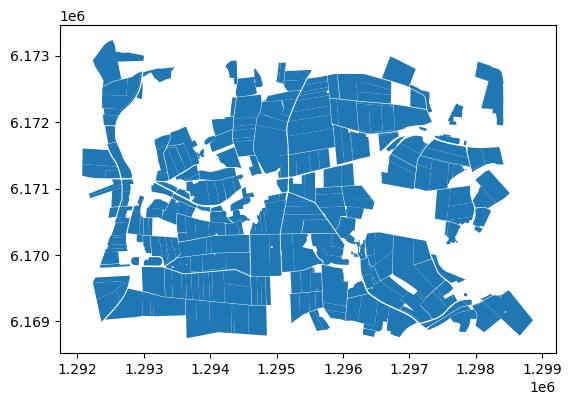

In [6]:
# plot shapefile for durnast in bavaria
durnast_shp.plot()

In [7]:
# each id represents a field / NC stands for the crop type
# Potatos: 600, 601, 602
# Winter barley: 476, 131
# Winter rapeseed: 311, 489
# Winter wheat: 115
# Corn: 400, 177, 171, 411, 410
# Sugar beet: 603

bavaria_train

,id,Date,area,NC,B1_mean,B2_mean,B3_mean,B4_mean,B5_mean,B6_mean,B7_mean,B8_mean,B8A_mean,B9_mean,B10_mean,B11_mean,B12_mean,NDVI_mean,NDRE_mean,REIP_mean
0,0,02-15,2.160921,115,1146.626562,831.977906,681.209049,436.757370,724.843314,2252.734038,3140.101011,3083.881444,3358.131258,1273.814711,8.160807,1151.194342,536.193014,0.752287,0.620349,727.821499
1,0,02-28,2.160921,115,1146.626562,831.977906,681.209049,436.757370,724.843314,2252.734038,3140.101011,3083.881444,3358.131258,1273.814711,8.160807,1151.194342,536.193014,0.752287,0.620349,727.821499
2,0,03-15,2.160921,115,1146.626562,831.977906,681.209049,436.757370,724.843314,2252.734038,3140.101011,3083.881444,3358.131258,1273.814711,8.160807,1151.194342,536.193014,0.752287,0.620349,727.821499
3,0,03-30,2.160921,115,1146.626562,831.977906,681.209049,436.757370,724.843314,2252.734038,3140.101011,3083.881444,3358.131258,1273.814711,8.160807,1151.194342,536.193014,0.752287,0.620349,727.821499
4,0,04-15,2.160921,115,1146.626562,831.977906,681.209049,436.757370,724.843314,2252.734038,3140.101011,3083.881444,3358.131258,1273.814711,8.160807,1151.194342,536.193014,0.752287,0.620349,727.821499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29381,2098,06-30,1.906676,600,1285.661774,936.870494,847.590695,507.814002,857.978602,2863.344055,3735.089244,3517.022161,3915.083618,691.954735,11.288811,1210.504010,504.571614,0.747310,0.607599,725.153626
29382,2098,07-15,1.906676,600,1182.304608,936.395201,1019.343203,561.450038,1211.869845,4210.337882,5354.164486,5291.569896,5685.073243,1443.635272,11.621614,2007.721245,837.813595,0.807566,0.626879,723.295172
29383,2098,07-30,1.906676,600,1165.151477,895.998243,853.525509,542.898523,913.233732,2093.492553,2555.416230,2395.194336,2745.797683,483.643750,9.323994,1223.778220,592.293470,0.629942,0.447528,721.534464
29384,2098,08-15,1.906676,600,1809.078278,1569.632364,1611.471525,1459.525929,1815.665460,2889.933439,3422.580983,3313.602431,3734.718406,871.586520,82.161106,2512.786934,1580.520838,0.388481,0.292266,723.232032


<AxesSubplot:>

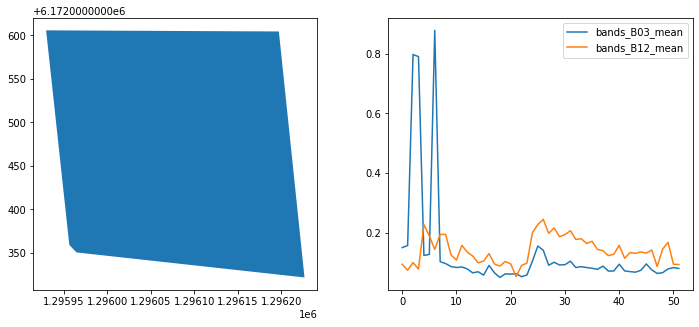

In [5]:
# plot field and corresponding timeseries L2A of Sentinel-2
# every field has a unique id, the labels are included in the shapefile and corresponding timeseries

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
durnast_ts[durnast_ts.id == '58cb970d59ab4e618787ff1aadd85599'][[
    'bands_B03_mean', 'bands_B12_mean']].plot(ax=ax2)
durnast_shp[durnast_shp.id == '58cb970d59ab4e618787ff1aadd85599'].plot(ax=ax1)

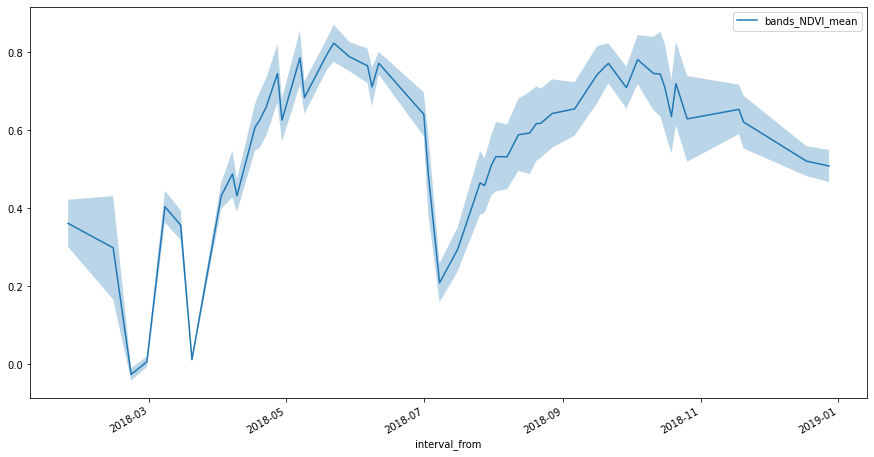

In [6]:
# plot corresponding NDVI timeseries L2A for a field
fig, ax = plt.subplots(figsize=(15, 8))
series = durnast_ts[durnast_ts.id == '58cb970d59ab4e618787ff1aadd85599']

series.plot(
    ax=ax,
    x='interval_from',
    y='bands_NDVI_mean')

ax.fill_between(
    series.interval_from.values,
    series['bands_NDVI_mean'] - series['bands_NDVI_stDev'],
    series['bands_NDVI_mean'] + series['bands_NDVI_stDev'],
    alpha=0.3
)

Crop type labels

In [7]:
durnast_ts[durnast_ts.id ==
           '58cb970d59ab4e618787ff1aadd85599'].crop_type.unique()

array([592])

In [10]:
# kenya and central asia shapefiles include information about the crop types
kenya_shp.head()

,Field ID,Latitude,Longitude,Accuracy,Survey Dat,Water Reso,Planting D,PlantingDa,Estimated,Crop1,...,Crop Densi,Variety,CMD Rating,CBSD Ratin,CGM Rating,Disease Ra,year,area,id,geometry
0,5.1,0.538299,34.22033,3.216,2019-05-16,rainfed,2018-08-13,Recorded,2019-06-13,Cassava,...,40,Tanzania,NULL,NULL,NULL,NULL,2019,826.800642,2df88b47161548139385021c5d0a9e8f,"POLYGON ((3809369.410 59931.195, 3809391.880 5..."
1,5.101,0.538204,34.22009,4.288,2019-05-16,rainfed,2019-03-01,Estimated,2019-12-01,Maize,...,50,Null,NULL,NULL,NULL,NULL,2019,53.561627,2190e01ec9334883909d34765a89f3ff,"POLYGON ((3809359.630 59913.943, 3809358.327 5..."
2,6.1,0.539152,34.22034,4.288,2019-05-16,rainfed,2019-04-03,Recorded,2020-01-03,Maize,...,60,DH 04,NULL,NULL,NULL,NULL,2019,3291.081675,5f59f6708fd94db698c5c23f57e3f601,"POLYGON ((3809393.373 60014.600, 3809367.658 6..."
3,6.101,0.539092,34.22031,3.216,2019-05-16,rainfed,2019-03-01,Estimated,2019-12-01,Maize,...,30,Null,NULL,NULL,NULL,NULL,2019,384.653307,89c6d8cc0c6342abb8d3905980dabaf8,"POLYGON ((3809392.104 60010.159, 3809412.520 6..."
4,6.2,0.539539,34.22064,4.288,2019-05-16,rainfed,2019-04-03,Recorded,2020-01-03,Maize,...,45,Null,NULL,NULL,NULL,NULL,2019,619.387388,5434f75b52e24ad38cffee7b7946eb77,"POLYGON ((3809423.021 60047.427, 3809405.652 6..."
